In [0]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import random
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

In [0]:
class PermutedMNISTDataLoader(torchvision.datasets.MNIST):
    
    def __init__(self, source='./mnist_data', train = True, shuffle_seed = None):
        super(PermutedMNISTDataLoader, self).__init__(source, train, download=True)
        
        self.train = train
        if self.train:
            self.permuted_train_data = torch.stack(
                [img.type(dtype=torch.float32).view(-1)[shuffle_seed] / 255.0
                    for img in self.train_data])
        else:
            self.permuted_test_data = torch.stack(
                [img.type(dtype=torch.float32).view(-1)[shuffle_seed] / 255.0
                    for img in self.test_data])
            
    def __getitem__(self, index):
        
        if self.train:
            input, label = self.permuted_train_data[index], self.train_labels[index]
        else:
            input, label = self.permuted_test_data[index], self.test_labels[index]
        
        return input, label

    def sample(self, size):
        return [img for img in self.permuted_train_data[random.sample(range(len(self), size))]]
    
    '''
    def __len__(self):
        if self.train:
            return self.train_data.size()
        else:
            return self.test_data.size()
    '''

#### Set hyperparameters & get permuted MNIST

In [3]:
batch_size = 64
learning_rate = 1e-3
num_task = 10
num_epochs = 20
sample_size = 100

criterion = nn.CrossEntropyLoss()

def permute_mnist():
    train_loader = {}
    test_loader = {}
    
    for i in range(num_task):
        shuffle_seed = np.arange(28*28)
        np.random.shuffle(shuffle_seed)
        train_loader[i] = torch.utils.data.DataLoader(
            PermutedMNISTDataLoader(train=True, shuffle_seed=shuffle_seed),
                batch_size=batch_size)
        
        test_loader[i] = torch.utils.data.DataLoader(
            PermutedMNISTDataLoader(train=False, shuffle_seed=shuffle_seed),
                batch_size=batch_size)
    
    return train_loader, test_loader

train_loader, test_loader = permute_mnist()

0it [00:00, ?it/s]

9920512it [00:01, 8706888.01it/s]                            


Extracting ./mnist_data/PermutedMNISTDataLoader/raw/train-images-idx3-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135463.36it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/PermutedMNISTDataLoader/raw/train-labels-idx1-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw


1654784it [00:00, 2340556.38it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist_data/PermutedMNISTDataLoader/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw


8192it [00:00, 54338.90it/s]            
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Extracting ./mnist_data/PermutedMNISTDataLoader/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


### Define Neural Net

In [0]:
class NeuralNet(nn.Module):
    def __init__(self):
        # Always start with inheriting torch.nn.Module
        # Ancestor class of all Neural Net module
        super(NeuralNet, self).__init__()
        # Linear: linear transformation
        fc1 = nn.Linear(28*28, 400)
        fc2 = nn.Linear(400, 400)
        fc3 = nn.Linear(400, 10)
  
        
        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        if torch.cuda.is_available():
            self.fc_module = self.fc_module.cuda()

    def forward(self, x):
        return self.fc_module(x)

### Get Fisher Matrix

In [0]:
def fisher(net, data_loader):
    dataiter = iter(data_loader)
    params = {n : p for n, p in net.named_parameters() if p.requires_grad}
    fisher_mat = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher_mat[n] = p.data

    net.eval()
    for input, label in dataiter:
        if torch.cuda.is_available():
            input = input.cuda()
            label = label.cuda()

        net.zero_grad()
        outputs = net(input)
        loss = criterion(outputs, label)
        loss.backward()

        for n, p in net.named_parameters():
            fisher_mat[n].data += p.grad.data ** 2 / len(input)

    return {n : p for n, p in fisher_mat.items()}

### Learning Function

In [0]:
def Learning_Function(net, optimizer, num_tasks, reg_coef, log_file, learn_mode = 0):
    if learn_mode > 2 or learn_mode < 0:
        print("Learn mode Error\nplain: 0\tpenalty with L2 distance: 1\tpenalty with ewc: 2")
        return False

    acc = {}
    params_per_tasks = []
    fisher_mat = []

    log_file.write("Task\tEpoch\n")
    for task in range(num_tasks):
        running_loss = 0.0
        
        # Train for each task
        for epoch in range(num_epochs):
            for i, data in enumerate(train_loader[task]):
                inputs, labels = data

                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # gradient initiallize
                optimizer.zero_grad()

                # Compute forward-propagation
                outputs = net(inputs)

                # Compute Loss
                loss = criterion(outputs, labels)

                # Compute Loss & L2 distance
                if learn_mode != 0:
                    reg = 0
                    ind = 0
                    for params_past in params_per_tasks:
                        for n, p in net.named_parameters():
                            penalty = (params_past[n] - p)**2
                            # EWC: multiply fisher matrix
                            if learn_mode == 2:
                                penalty = fisher_mat[ind][n] * penalty#torch.dot(fisher_mat[ind][n], penalty)

                            reg += torch.sum(penalty)
                        ind += 1
                    loss = loss + (reg_coef / 2) * reg

                #Do Back-propagation
                loss.backward()
                #Weight update
                optimizer.step()

                #cumulate loss
                running_loss += loss.data.item()

            if epoch % 5 == 4:
                log_file.write("[%d\t%d] AVG. loss: %.3f\n"% (task+1, epoch + 1, running_loss/(i*5)))
                running_loss = 0.0
            
        # Test for each task after learning a task.
        each_task_acc = []
        for j in range(task+1):
            total = 0
            correct = 0
            for i, data in enumerate(test_loader[j]):
                inputs, labels = data
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # forward propagation
                outputs = net(inputs)

                # torch.max: returns maximum value of a tensor
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                
                # Estimate accuracy of model
                correct += (predicted == labels).sum()
                                
            each_task_acc.append(100 * correct.cpu().numpy() / total)
            
        each_task_acc = np.asarray(each_task_acc)
        #log_file.write(" ".join(each_task_acc))
        log_file.write('Average accuracy after training task %d: %d %%\n' % (task+1, np.mean(each_task_acc)))
        acc[task] = np.mean(each_task_acc)
            
        # Save parameters to use at next iteration: used to cal. penalty term      
        if learn_mode != 0:
            tp = {n : p for n, p in net.named_parameters() if p.requires_grad}
            params = {}
            #for n, p in deepcopy(tp).items():
            for n, p in tp.items():
                params[n] = p.data.clone()
                if torch.cuda.is_available(): # If cuda available, change Tensor to GPU Tensor
                    params[n] = params[n].cuda()

            params_per_tasks.append(params)

            # If learning mode is cont. learnig with ewc: make fisher mat. and save it
            if learn_mode == 2:
                fisher_mat.append(fisher(net, train_loader[task]))
            
    return acc

### Fine Tuning

In [0]:
def Plain_SGD_Learning(learning_rate, num_task):
    dt = datetime.datetime.now()    
    logfile_name = "logfile_training_finetune_%d_%d_%d_%d_%d.txt" % (dt.year, dt.month, dt.day, dt.hour, dt.minute)
    log_file = open(logfile_name, "w")

    net = NeuralNet()
    if torch.cuda.is_available():
        print("Use GPU")
        net.cuda()
        
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    acc = Learning_Function(net, optimizer, num_task, reg_coef=1, log_file, learn_mode=0)
    log_file.close()
    return acc

### Continual Learning with L2 distance

In [0]:
def L2_Learning(learning_rate, num_task):
    dt = datetime.datetime.now()    
    logfile_name = "logfile_training_L2_%d_%d_%d_%d_%d.txt" % (dt.year, dt.month, dt.day, dt.hour, dt.minute)
    log_file = open(logfile_name, "w")

    learning_acc = {}
    reg_coef_list = [30, 100, 300,1000,3000,10000]
    
    for reg_coef in reg_coef_list:
        log_file.write("REG Coefficient = %d\n"%(reg_coef))
        net = NeuralNet()
        if torch.cuda.is_available():
            print("Use GPU")
            net.cuda()
            
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)    
        print("Penalty term coefficient: ", reg_coef)
        learning_acc[reg_coef] = Learning_Function(net, optimizer, num_task, reg_coef, log_file, learn_mode=1)
        log_file.write("\n")

    log_file.close()
    return learning_acc

### Continual Learning with Elastic Weight Consolidation

In [0]:
def EWC_Learning(learning_rate, num_task):
    dt = datetime.datetime.now()
    logfile_name = "logfile_training_ewc_%d_%d_%d_%d_%d.txt" % (dt.year, dt.month, dt.day, dt.hour, dt.minute)
    log_file = open(logfile_name, "w")

    learning_acc = {}
    reg_coef_list = [100, 110, 120]
    
    for reg_coef in reg_coef_list:
        log_file.write("REG Coefficient = %d\n"%(reg_coef))
        net = NeuralNet()
        if torch.cuda.is_available():
            print("Use GPU")
            net.cuda()
            
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)    
        print("Penalty term coefficient: ", reg_coef)
        learning_acc[reg_coef] = Learning_Function(net, optimizer, num_task, reg_coef, log_file, learn_mode=2)
        log_file.write("\n")

    log_file.close()
    return learning_acc

In [0]:
SGD_acc = Plain_SGD_Learning(learning_rate, num_task)

Use GPU
Task	Epoch


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[1	5] AVG. loss: 2.111
[1	10] AVG. loss: 1.069
[1	15] AVG. loss: 0.569
[1	20] AVG. loss: 0.443
[89.14]
[89.14]
Average accuracy after training task 1: 89 %


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[2	5] AVG. loss: 0.786
[2	10] AVG. loss: 0.436
[2	15] AVG. loss: 0.373
[2	20] AVG. loss: 0.340
[86.53, 90.9]
[86.53 90.9 ]
Average accuracy after training task 2: 88 %
[3	5] AVG. loss: 0.643
[3	10] AVG. loss: 0.388
[3	15] AVG. loss: 0.342
[3	20] AVG. loss: 0.314
[79.7, 87.65, 91.49]
[79.7  87.65 91.49]
Average accuracy after training task 3: 86 %
[4	5] AVG. loss: 0.605
[4	10] AVG. loss: 0.369
[4	15] AVG. loss: 0.326
[4	20] AVG. loss: 0.300
[77.31, 82.56, 89.13, 91.94]
[77.31 82.56 89.13 91.94]
Average accuracy after training task 4: 85 %
[5	5] AVG. loss: 0.596
[5	10] AVG. loss: 0.349
[5	15] AVG. loss: 0.306
[5	20] AVG. loss: 0.280
[75.08, 76.49, 82.57, 86.03, 92.41]
[75.08 76.49 82.57 86.03 92.41]
Average accuracy after training task 5: 82 %
[6	5] AVG. loss: 0.574
[6	10] AVG. loss: 0.339
[6	15] AVG. loss: 0.296
[6	20] AVG. loss: 0.269
[72.97, 73.89, 77.2, 78.82, 89.23, 92.71]
[72.97 73.89 77.2  78.82 89.23 92.71]
Average accuracy after training task 6: 80 %
[7	5] AVG. loss: 0.554
[7	10

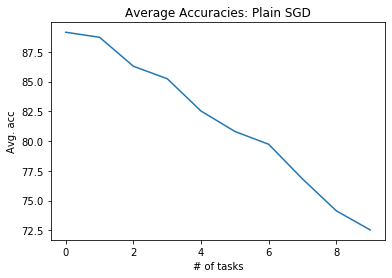

In [0]:
x, y = list(SGD_acc.keys()), list(SGD_acc.values())
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies: Plain SGD")
plt.plot(x, y)
plt.show()

In [0]:
L2_acc = L2_Learning(learning_rate, num_task)

Use GPU
Penalty term coefficient:  30


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Use GPU
Penalty term coefficient:  100
Use GPU
Penalty term coefficient:  300


In [0]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies w.r.t. regularization rates: EWC")

for coef, acc_dict in L2_acc.items():
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))

plt.legend(loc=3)
plt.show()

In [8]:
EWC_acc = EWC_Learning(learning_rate, num_task)

Use GPU
Penalty term coefficient:  100


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Use GPU
Penalty term coefficient:  110
Use GPU
Penalty term coefficient:  120


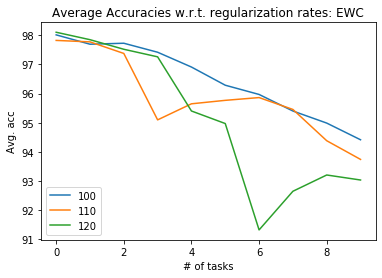

In [9]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies w.r.t. regularization rates: EWC")

for coef, acc_dict in EWC_acc.items():
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))

plt.legend(loc=3)
plt.show()

## 더 해야할 것들
1. 결과 로그남기기
2. RADAR Data plain sgd로 돌려보기 (90% 이상 나와야 된다고 함)
3. 논문
...
